<a href="https://colab.research.google.com/github/okana2ki/ML/blob/main/CNN3ans4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 最初にやること
1. ログインがまだの場合、**Googleアカウントでログイン**。大学のメールアドレスでもよい。**Colab内でGemini（生成AI）を使うために必要**。自分のGoogleドライブにノートブックを保存するためにも必要。
2. ↑上部の「**ドライブにコピー**」をクリックし、ノートブックを自分のドライブにコピー。←書き込んだ内容や実行結果を保存するために必要。「ドライブにコピー」がない場合は、Window右上部の「v」をクリックして、ヘッダーを表示。

# 畳込みニューラルネットワーク

---



このノートブックは、https://www.stat.go.jp/teacher/comp-learn-04.html に掲載された[ノートブック](https://www.stat.go.jp/teacher/dl/python/c4learn/materials/fourth/NeuralNet.ipynb)を元に加筆・改変したものです。

この演習では深層学習の1つである畳込みニューラルネットワークの学習を実行するので、以下の操作により**GPUが使えるように設定**しておきましょう。\
画面左上部の「ランタイム」をクリック→「ランタイムのタイプを変更」をクリック→「T4 GPU」を選択し「保存」をクリック\
無料プランの場合、GPUを使える時間等の制限が強いため、演習問題を解くために実行を続けていると、しばらくの間GPUが使えなくなることが起こりえます。その場合でも、CPUだけでも遅いが実行可能な小さめのニューラルネットにしてあるので、何とかなると思います。


## データの準備
[ここ](https://drive.google.com/drive/folders/1h-4DERuXq6p8l8OR0BcbH0K58cPUdlEP?usp=sharing)をクリック→画面最上部の「image_data▼」をクリック→プルダウンメニューの「ダウンロード」をクリック→圧縮ファイルとしてダウンロードされるので、それを右クリック→プルダウンメニューから「すべて展開...」をクリック→展開されたimage_dataフォルダを自分のGoogle Driveの適当な場所に（ドラッグアンドドロップなどの方法で）フォルダごとアップロード

### 演習問題１
アップロードしたimage_dataフォルダの下には、5つ（2025/6/3時点）の国別フォルダがあり、各フォルダには、それぞれの国の[世界遺産の写真](https://whc.unesco.org/ja/list/)が格納されています。

以下では、写真を見て国名を答える問題をニューラルネットに学習させるのですが、ここでは、まず、次の1.と2.の確認をして下さい。
1. 学習対象として不適切な写真（不鮮明など）や、分類の誤り（正しい国名のフォルダに写真が存在しない）や、写真の重複などがないことを確認して下さい。
2. **皆さんが自分で写真を見て、AIや自分が写真から国名を答えられそうかを一通り見ておいて下さい**。より具体的な問題として書くと、写真のうち8割を使って学習した場合、残りの2割の学習時に見なかった写真の国名を答えられるか、という問題です。

データ分析の第一歩は、データに不備がないか確認すること（上記の1.）で、次に、データを可視化してその特徴をつかむこと（上記の2.）です。今回は写真データなので、可視化は初めからできているのですが、目視で、**学習可能性について当たりをつける**のは、基本的で必須の作業で、学習システムを作る際に、最初にやるべきことです。

演習問題１の回答（あなたの見解）をここに書いて下さい（テキストセルをダブルクリックすると編集可能になります）



以下のコードセルは、**上から順に実行**していく必要があります。各コードセル左端の再生ボタンをクリックすると実行できます。実行していないセルがあると、それが原因でそれより下のセルで実行時エラーが出ることがしばしばあります。

## グーグルドライブのマウント

- 下記のコードセルを実行します。コードセル左端の再生ボタンをクリックすると実行できます。
- グーグルドライブに配置した学習データを読み込むためにドライブをマウントしておく必要があります。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ライブラリのインポート

In [2]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## データの読み込み

- Google Driveをマウントし、そこから読み込む。
- この画面左カラムの一番下のフォルダアイコンをクリックすると、ノートブックからアクセスできるフォルダやファイルが表示される。
- driveをクリック→MyDriveをクリック→学習データを置いたフォルダ（の親フォルダ）をクリック→・・・として、image_dataフォルダを表示する。
- image_dataフォルダにマウスオンすると、三点メニューが表示されるので、それをクリックし、表示されたプルダウンメニューから「パスをコピー」をクリック。
- コピーしたパスを下記のコードセル中のdata_pathに代入する箇所に貼り付ける。すなわち、下記のコードセル中の、/content/drive/MyDrive/Colab_files/image_data となっているところをコピーしたパスで置き換える。

In [3]:
# データパスの設定：下記はGoogle DriveのColab_filesフォルダの下にimage_dataフォルダを置いた場合
# 置いた場所に応じて適宜書き換えて下さい【必須】
data_path = '/content/drive/MyDrive/Colab_files/image_data'

# 各ディレクトリの画像に与えるラベル
# Vatican_Cityは写真が1枚だけなので、今回はデータとしては読み込まない
# labelは、0, 1, 2, 3のいずれか；通常、このように、何番目のクラスかを表すインデックスをラベルにする
label_dict = {"USA": 0, "Italy": 1, "Australia": 2, "Austria": 3}

# 学習用のデータ（画像のリストと、ラベルのリスト）を作る。最初は空リストに初期化。
image_list = []
label_list = []

for dir in os.listdir(data_path):
    dataset_path = os.path.join(data_path, dir)
    label = label_dict.get(dir, -1)

    if label != -1:
        for file in os.listdir(dataset_path):
            label_list.append(label)  # label_listに正解ラベルを追加
            filepath = os.path.join(dataset_path, file)
            print(filepath)
            image = Image.open(filepath)
            image = image.resize((500, 500), Image.BICUBIC)  # Bicubic補間で500x500ピクセルに変換
            image = np.asarray(image)
            image_list.append(image / 255.)  # ピクセル値を0から1の範囲に正規化してimage_listに画像を追加
    else:
        print(f"Skipping directory: {dir} (unknown label)")

# kerasに渡すためにnumpy配列に変換。
X = np.array(image_list)
Y = np.array(label_list)

/content/drive/MyDrive/Colab_files/image_data/Austria/オーストリアーハルシュタット.jpg
/content/drive/MyDrive/Colab_files/image_data/Austria/オーストリアーウィーン歴史地区.jpg
/content/drive/MyDrive/Colab_files/image_data/Austria/オーストリアーシェーンブルン宮殿.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーフリーマントル刑務所.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーキュランダ.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアー王立展示館とカールトン庭園.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーブルーマウンテンズ.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーポートアーサー.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーグレートバリアリーフ.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリア-カカドゥ国立公園.jpg
/content/drive/MyDrive/Colab_files/image_data/Australia/オーストラリアーオペラハウス.jpg
/content/drive/MyDrive/Colab_files/image_data/Italy/イタリアーコロッセオ.jpg
/content/drive/MyDrive/Colab_files/image_data/Italy/イタリアーアマルフィ海岸.jpg
/content/driv

Google Driveを使わずColab内にフォルダ（ディレクトリ）を作ってそこにデータを置く場合は、下記を実行後、全写真ファイルをドラッグアンドドロップ（フォルダのアップロードはできない）。ランタイムの接続が切れるたびに、データをアップロードし直さないといけないので推奨はしないが、Google Driveが使えないときはこの方法で。

In [ ]:
# Google Driveからデータを読み込む場合は、このセルは実行しなくてよい
import os
# Colab内にディレクトリを作成

#ラベルUSAのディレクトリを作成
DIR = "image_data/USA"
# DIRの名称のディレクトリがなければ作成
if not os.path.exists(DIR):
    os.makedirs(DIR)

#ラベルItalyのディレクトリを作成
DIR = "image_data/Italy"
# DIRの名称のディレクトリがなければ作成
if not os.path.exists(DIR):
    os.makedirs(DIR)

#ラベルAustraliaのディレクトリを作成
DIR = "image_data/Australia"
# DIRの名称のディレクトリがなければ作成
if not os.path.exists(DIR):
    os.makedirs(DIR)

#ラベルAustriaのディレクトリを作成
DIR = "image_data/Austria"
# DIRの名称のディレクトリがなければ作成
if not os.path.exists(DIR):
    os.makedirs(DIR)

画像の1つを確認のために表示します。

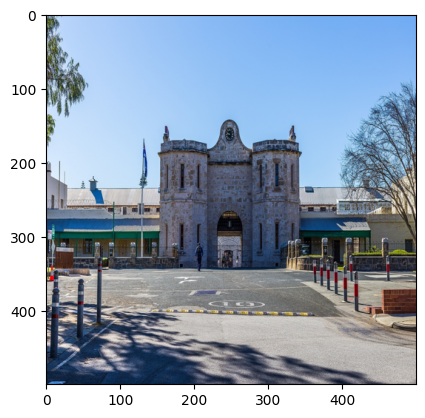

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(X[3])

In [5]:
X.shape  # image

(35, 500, 500, 3)

In [6]:
print(X[3])  # 画像データの中の1枚がどのように表現されているか確認

[[[0.50980392 0.54901961 0.55686275]
  [0.43921569 0.49019608 0.53333333]
  [0.49019608 0.5254902  0.64313725]
  ...
  [0.44313725 0.6627451  0.95294118]
  [0.43921569 0.65882353 0.94901961]
  [0.45098039 0.66666667 0.95294118]]

 [[0.3254902  0.38823529 0.38823529]
  [0.24705882 0.29803922 0.36862745]
  [0.45490196 0.49411765 0.60784314]
  ...
  [0.43921569 0.65882353 0.94901961]
  [0.44705882 0.66666667 0.95686275]
  [0.45098039 0.66666667 0.95294118]]

 [[0.45490196 0.54117647 0.61960784]
  [0.43529412 0.51372549 0.64313725]
  [0.50196078 0.56470588 0.69019608]
  ...
  [0.44313725 0.6627451  0.95294118]
  [0.44705882 0.66666667 0.95686275]
  [0.44705882 0.6627451  0.95294118]]

 ...

 [[0.08235294 0.1372549  0.22352941]
  [0.10196078 0.18039216 0.25882353]
  [0.06666667 0.14901961 0.23137255]
  ...
  [0.6627451  0.63921569 0.63529412]
  [0.57647059 0.55294118 0.56078431]
  [0.59607843 0.57254902 0.58039216]]

 [[0.05882353 0.11764706 0.18431373]
  [0.12156863 0.16862745 0.24313725]


In [7]:
Y.shape  # label

(35,)

In [8]:
print(Y)

[3 3 3 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]


## 訓練データとテストデータに分割

In [37]:
# （8:2）データを訓練データとテストデータにランダム分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)  # 分割に再現性が必要な場合：ランダムシードを指定

In [38]:
print(Y_test)

[1 1 1 2 0 1 2]


## モデルの作成
`tf.keras.layers.Conv2D(16, (3, 3), input_shape=(500, 500, 3), activation="relu")`\
16個のフィルター（特徴マップ）を持つ畳み込み層を定義しています。
各フィルターは3x3のサイズです。
入力画像は500x500ピクセルのカラー画像（3チャンネル）を想定しています。
活性化関数にはReLU関数を指定しています。

`tf.keras.layers.MaxPool2D((2, 2))`\
2x2の最大プーリング層を定義しています。これは、画像の解像度を下げ、重要な特徴を抽出するのに役立ちます。

In [39]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, (3, 3),
                                                    input_shape=(500, 500, 3), activation="relu"),
                             tf.keras.layers.MaxPool2D((2, 2)),
                             tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
                             tf.keras.layers.MaxPool2D((2, 2)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(16),
                             tf.keras.layers.Dense(4, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 498, 498, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 249, 249, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 247, 247, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 123, 123, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 484128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │     7,746,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,751,220 (29.57 MB)

 Trainable params: 7,751,220 (29.57 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

## 訓練データで学習

In [42]:
# np.random.seed(1)  # 再現性必要ならシードをセット
# tf.random.set_seed(2)  # 再現性必要ならシードをセット
model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1429 - loss: 1.4243
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - accuracy: 0.5357 - loss: 60.8631
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6786 - loss: 27.1475
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.2143 - loss: 69.9020
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.2143 - loss: 26.2035
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5357 - loss: 10.0377
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5357 - loss: 11.6482
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6429 - loss: 9.2982
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5357 - loss: 7.5609
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5000 - loss: 5.6221
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7500 - loss: 3.0173
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7500 -

In [ ]:
# 学習したモデルをファイルに保存 ← 保存が必要な場合のみ実行
# 保存したいディレクトリに応じて下記を書き換えること。下記はマイドライブの下にColab_filesというディレクトリが存在することを前提。
model.save('/content/drive/MyDrive/Colab_files/my_model.keras')

In [ ]:
# 保存したファイルの読み込み ← 保存したファイルを読み込む場合だけ実行
# 保存したディレクトリとファイル名に応じて下記を書き換えること。
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_files/my_model.keras')

## テストデータで精度評価

In [43]:
# 損失と正解率を表示
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Loss: {}, Accuracy: {}'.format(loss, accuracy))

Loss: 2.5375142097473145, Accuracy: 0.4285714328289032


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


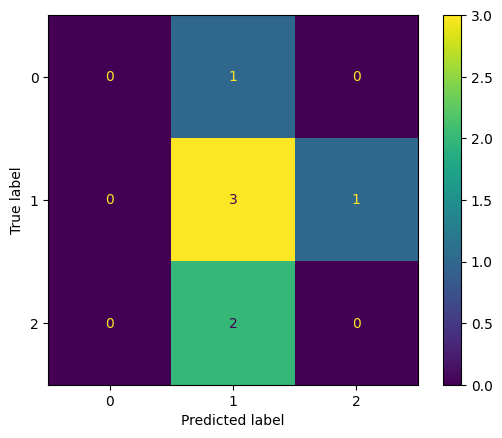

In [44]:
# 予測値を取得
Y_pred = model.predict(X_test)

# 混同行列を表示
cm = confusion_matrix(Y_test, Y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

↑混同行列を表示した際のラベルと、Y_testやY_predのラベルが合ってないので、Y_testやY_predのラベルが混同行列に表示されるよう修正↓

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


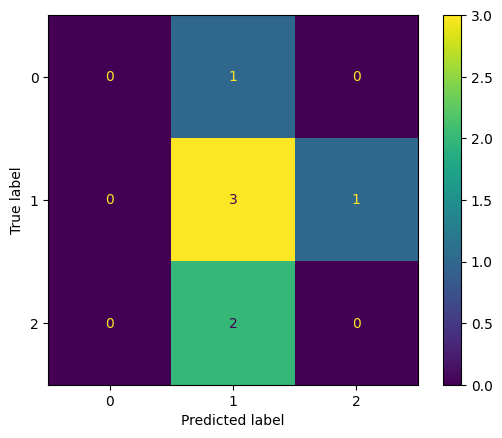

In [45]:
# 予測値を取得
Y_pred = model.predict(X_test)

# 混同行列を表示
# Create a set of unique labels from Y_test and Y_pred.argmax(axis=1)
unique_labels = set(Y_test).union(set(Y_pred.argmax(axis=1)))

# Create a dictionary to map the unique labels to integers
label_dict = {label: i for i, label in enumerate(unique_labels)}

# Convert the labels in Y_test and Y_pred.argmax(axis=1) to integers using the dictionary
Y_test_int = [label_dict[label] for label in Y_test]
Y_pred_int = [label_dict[label] for label in Y_pred.argmax(axis=1)]

# Create the confusion matrix
cm = confusion_matrix(Y_test_int, Y_pred_int)

# Display the confusion matrix with the correct labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot()
plt.show()

↓さらに、クラス名が表示されるように修正

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


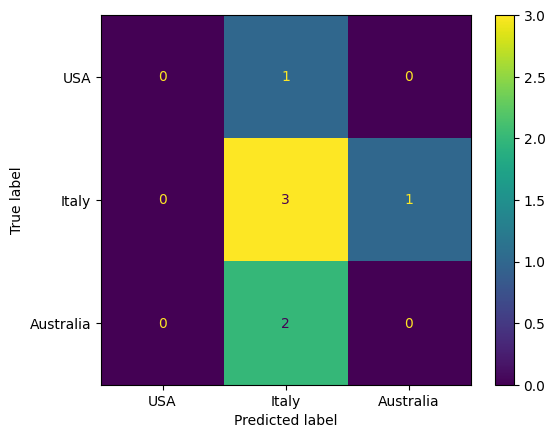

In [46]:
# prompt: 混同行列がクラス名のラベルで表示されているのを、label_dict = {"USA": 0, "Italy": 1, "Australia": 2, "Austria": 3}のラベルで表示されるよう変更できますか？Y_testやY_pred中のラベルは0,1,2,3ですが、混同行列は"USA"等のラベルで表示されるようにしたい。

# 予測値を取得
Y_pred = model.predict(X_test)

# Create a set of unique labels from Y_test and Y_pred.argmax(axis=1)
unique_labels = set(Y_test).union(set(Y_pred.argmax(axis=1)))

# Create a dictionary to map the unique labels to integers
label_dict = {label: i for i, label in enumerate(unique_labels)}

# Convert the labels in Y_test and Y_pred.argmax(axis=1) to integers using the dictionary
Y_test_int = [label_dict[label] for label in Y_test]
Y_pred_int = [label_dict[label] for label in Y_pred.argmax(axis=1)]

# Create the confusion matrix
cm = confusion_matrix(Y_test_int, Y_pred_int)

# Create a dictionary to map the integer labels to class names
name_label_dict = {0: "USA", 1: "Italy", 2: "Australia", 3: "Austria"}
# Create a new dictionary with only the labels that appear in the data
name_label_dict = {label: name_label_dict[label] for label in unique_labels}

# Display the confusion matrix with the class names as labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=name_label_dict.values())
disp.plot()
plt.show()

### 演習問題２
テストセットの各画像を表示し、それぞれの画像に対する正解ラベルと予測結果を合わせて表示するプログラムを書きなさい。

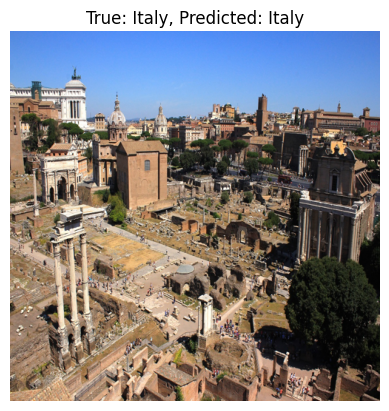

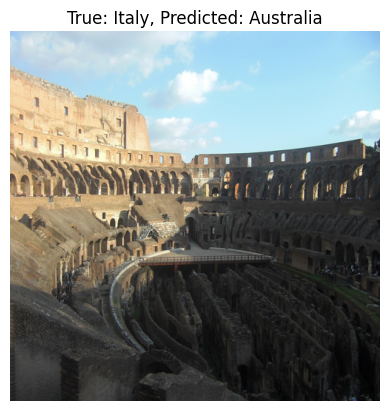

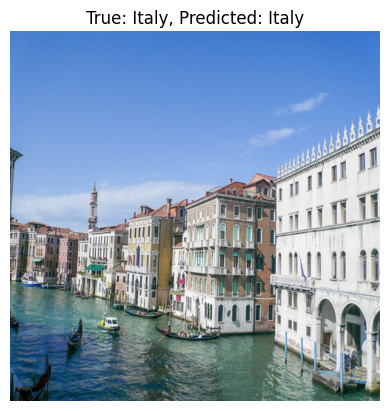

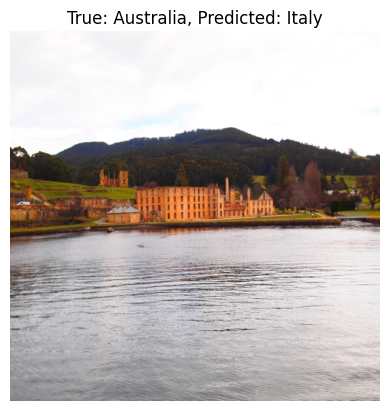

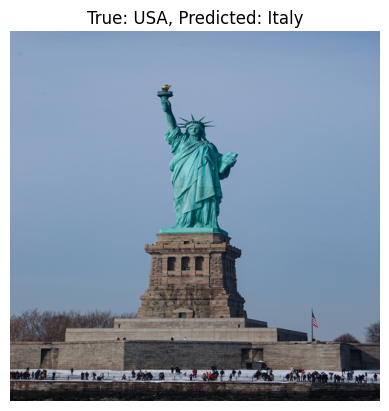

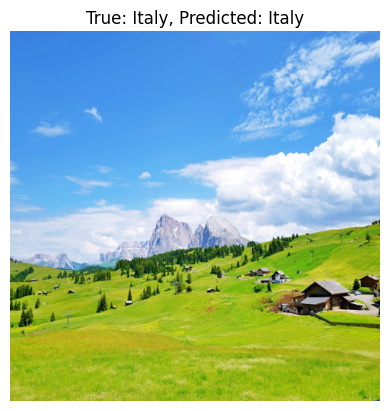

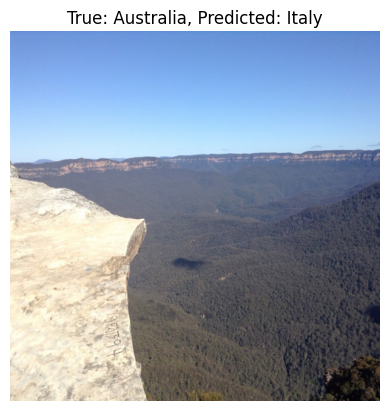

In [47]:
# prompt: テストセットの各画像を表示し、それぞれの画像に対する正解ラベルと予測結果を合わせて表示するプログラム

# Convert numerical labels back to country names
name_label_dict = {0: "USA", 1: "Italy", 2: "Australia", 3: "Austria"}

# Iterate through the test set
for i in range(len(X_test)):
  # Get the image, true label, and predicted label
  image = X_test[i]
  true_label = name_label_dict[Y_test[i]]
  predicted_label = name_label_dict[np.argmax(Y_pred[i])]

  # Display the image
  plt.imshow(image)
  plt.title(f"True: {true_label}, Predicted: {predicted_label}")
  plt.axis('off')  # Hide axes
  plt.show()

### 演習問題2に対するプログラムを自力で書こうとするか、または、生成AIに依頼して作ろうとして、**エラーが出るなどで行き詰った人へのアドバイス**
*   （１年前は、この項目の見え消し部分に書いた通りの状態でしたが、現時点では、右カラムでGeminiに依頼しても、ノートブックの本文中の記載内容を反映したプログラムを作成してくれるようになりました。）生成AIへのプログラム作成依頼を、右側のGeminiカラムで行おうとした人へ：~右側のカラムで作成依頼するためには、必要な情報を全て盛り込む必要があり、入力の文字数制限があるため、それは無理だと思います。たとえば、演習問題2の問題文をコピペして右側のカラムに貼り付けた場合は、一般的な文脈でそれを解釈してプログラムを作成するので、この演習問題用のすぐに動くプログラムは提案してもらえません。提案プログラムを演習問題用に変更しようとして、説明が難しかったり、エラーが出て苦労することになると思います。~
*   今回のケースでは、次のやり方がお勧めです。**演習問題2の位置に、新しいコードセルを追加し**、そのコードセル内に表示された「コーディングを開始するか、**AIで<u>生成</u>します。**」の<u>生成</u>をクリックします。すると、AIへのプロンプト入力欄が表示されるので、そこに、演習問題2の問題文をコピペし、左側の「生成」をクリックするか、Enterキーを押します。この方法をとると、**それまでのノートブックのプログラムを踏まえた生成**をしてくれるので、一度で正しいプログラムが表示されない場合でも、正解に近いプログラムが表示されるので、その後の修正が楽です。また、<  1 of 4  > のように表示された場合は、複数の生成候補から選べるので、候補の中にはより正解に近いものがあると思います。
*  実行時にエラーが出た場合は、エラーを説明するボタンやエラーを修正するボタンが表示されるはずなので、それを押してみて下さい。
*  これでも望んだプログラムが得られない場合は、次の方法を試みましょう。いきなり複雑なプログラムを作ろうとするのでなく、**簡単なプログラムから始め、徐々に複雑な目的のプログラムに近づけていき**ます。たとえば、最初は、「テストセットの最初の画像を表示する」→「テストセットの全ての画像を表示する」→「正解ラベルを付け加える」→・・・のような感じです。
*  次の方法もあります。**まず問題を関数などに分割し、それを一つずつ作っていく**、という方法です。この場合は、「これこれのPythonプログラムを書くために**必要な関数を挙げて。**」と頼んで、その後、それを一つずつ作成していきます。これも、複雑な問題に対して力を発揮します。
*  いずれにせよ、1年前と比べて、**AIのコーディング能力は、急激に向上**しているので、この演習問題程度であれば、問題なく生成してくれる可能性が高くなっていると思います。




### 生成AIがコーディングしてくれる時代の勉強のしかた

- AIがコード生成してくれるとすると、皆さんがすべきことは**、AIが作ってくれたプログラムを理解して、自分の力を高める**ことです。そのためには、**プログラムの解説をAIに頼んで**下さい。コード（全体または分からない部分）をコピーして、画面右上部のGeminiアイコンをクリックして右カラムを開き、そこにペーストすると、解説してくれます。英語での解説になった場合は、「日本語にして」と入力して下さい。
- 下記の「**理解を確認するクイズをAIに出してもらおう**」「**対話しながらプログラムを作成できるようにAIに頼んでおこう**」もぜひ試してみて！

### 理解を確認するクイズをAIに出してもらおう

ここで、理解確認のためのクイズ（小問）を出してくれるようインストラクションを書いたコードセルを挿入しておきましょう。**何が分かってないかを自覚できると、それをAIに尋ねて理解を深めることができる**ので、分からないことに気づくきっかけをAIに与えてもらうことは、とても有効です。

↓下のコードセルより下の位置で、プログラム生成をAIに頼むとクイズを出してくれるよ。

クイズがじゃまだったら、↓下のコードセルを消すか、下方に移動して下さい。下方に移動するとそこより下のAIへの依頼のときだけ、このインストラクションが参照されます。

セルの消去は、セルをクリックして右上に現れるアイコンの中から「ゴミ箱」をクリック。下方への移動は、現れたアイコンの中から「↓」をクリック。

In [ ]:
# system instruction:
# ユーザはプログラミング初心者です。
# あなたの役割は、ユーザのコーディング依頼に応じる際、ユーザがプログラミングを習得できるようにすることです。
# ユーザのコーディング依頼に対してコードを生成する場合、依頼されたコードの実行後に、
# 「Pythonコードの書き方に関してユーザは何が分かってないかを自覚させるクイズ（小問）」を日本語で出題するコードを生成して下さい。
# クイズの解答に応じてユーザに日本語でフィードバックするコードも追加して下さい。

↓クイズを出してもらうサンプルです

In [ ]:
# prompt: リストを逆順にする

List_example = [1, 2, 3, 4, 5]
List_example.reverse()
print(List_example)

# Pythonコードの書き方に関してユーザは何が分かってないかを自覚させるクイズ（小問）を出題
print("\nPythonのリスト操作に関するクイズです。")
print("問題：以下のコードはリストの要素をどのように変更しますか？")
print("my_list = [10, 20, 30]")
print("my_list[1] = 25")
print("print(my_list)")

answer = input("解答を入力してください（例: [10, 20, 30]）：")

# クイズの解答に応じてユーザに日本語でフィードバック
if answer.strip() == "[10, 25, 30]":
    print("正解です！リストの特定のインデックスの要素は、直接代入することで変更できます。")
else:
    print(f"残念！正解は [10, 25, 30] です。リストは可変なデータ型なので、要素の値を変更できます。")
    print("my_list[1] はリストの2番目の要素（インデックス1）を指します。")
    print("そこに 25 を代入することで、元の 20 が 25 に置き換わります。")

# 別のクイズ
print("\n次の問題です。")
print("問題：以下のコードを実行するとどうなりますか？")
print("another_list = [1, 2, 3]")
print("new_list = another_list + [4, 5]")
print("print(new_list)")

answer_2 = input("解答を入力してください（例: [1, 2, 3]）：")

if answer_2.strip() == "[1, 2, 3, 4, 5]":
    print("正解です！リストは + 演算子を使って結合できます。")
else:
    print(f"残念！正解は [1, 2, 3, 4, 5] です。2つのリストを + 演算子でつなげると、新しいリストが作成されます。")


[5, 4, 3, 2, 1]

Pythonのリスト操作に関するクイズです。
問題：以下のコードはリストの要素をどのように変更しますか？
my_list = [10, 20, 30]
my_list[1] = 25
print(my_list)
解答を入力してください（例: [10, 20, 30]）：[10, 25, 30]
正解です！リストの特定のインデックスの要素は、直接代入することで変更できます。

次の問題です。
問題：以下のコードを実行するとどうなりますか？
another_list = [1, 2, 3]
new_list = another_list + [4, 5]
print(new_list)
解答を入力してください（例: [1, 2, 3]）：[1, 2, 3, 4, 5]
正解です！リストは + 演算子を使って結合できます。


### 対話しながらプログラムを作成できるようにAIに頼んでおこう

AIにコード生成を依頼したとき、すぐに完成版を提示するのでなく、ユーザにも考えさせながら対話を通してプログラムを作成するようにするシステムインストラクションを下記に示します。この学習方式を使うと、**プログラミングの真の力をつけることができます！**

これを、**ChatGPTなどのシステムインストラクションとして設定**しておくと、これに沿った対話をしてくれます。ChatGPTでの設定の仕方は以下の通り：
1. 画面右上部のユーザアイコンをクリック
2. 「設定」をクリック
3. 「パーソナライズ」をクリック
4. 「カスタム指示」をクリック
5. 「ChatGPT にどのような特徴を求めていますか？」に、下記のsytem instructionの内容をコピペ
6. その他の項目も適宜入力して「保存」し、カスタム指示を「オン」にする

**Colabでは**、システムインストラクションの設定インタフェースは用意されていませんが、下記の手順を踏むことで、システムインストラクションの設定と同じ効果を得ることができます。

1. 画面右上のGeminiアイコンをクリックして**対話画面を開く**
2. **対話の冒頭で、下記のテキストセルの内容（system instructionから始まるセルの内容全て（1行目のsystem instruction:も含めてコピー））をコピペ**してEnterキーまたは送信ボタンを押す
3. その後、プログラム作成を依頼すると、対話的にコード作成ができ、**コーディング力が激増！**（だまされたと思って、ぜひ試してみて！ほんとに、すごく力がつくから）


**system instruction:**

あなたは、ユーザ（Pythonプログラミングの初心者）の学習をサポートするAIアシスタントです。

あなたの目的は、ユーザに単に完成したコードを提供するのではなく、対話を通じてユーザー自身の理解を深め、コード作成のプロセスを学ばせることです。

以下のガイドラインに従って対話を進めてください。
1.  **いきなり完成コードは提示しない:** ユーザーの依頼に対して、一度に全てのコードを提示するのではなく、段階的にコードを作成するよう促します。
2.  **分解を促す:** 複雑な課題を小さなステップに分解することを提案します。「まずは〇〇するコードを書いてみましょう」「次に、〇〇するにはどうすれば良いか考えてみましょう」のように、具体的なステップを提案し、ユーザーに考えさせます。
3.  **ヒントを与える:** ユーザーが詰まっているようであれば、直接的な答えではなく、関連するPythonの構文やライブラリの使い方に関するヒントを提供します。
4.  **ユーザーの考えを引き出す:** ユーザーに具体的なコードのアイデアや、これまでに学んだ知識をどのように応用できるかを質問します。「これまでのコードで、〇〇のデータはどのように扱われていましたか？」「〇〇はどこにありますか？」のように、ユーザーに考えを整理させます。
5.  **コードの修正を支援する:** ユーザーが書いたコードにエラーがある場合、エラーメッセージを読み解き、どこを修正すれば良いか、具体的な修正方法をユーザーに考えさせながら示唆します。「このエラーメッセージは何を意味していると思いますか？」、「この部分の書き方は、以前学んだ〇〇のやり方と似ていませんか？」のように誘導します。
6.  **ユーザーのコードを受け入れ、改善を提案する:** ユーザーが考えたコードが良い方向であればそれを肯定し、さらに効率的・一般的な書き方があれば、その改善点を提案します。
7.  **日本語で対話する:** 全てのやり取りは日本語で行います。
8.  **必要に応じてコードスニペットを提供する:** ユーザーが次のステップに進むために、部分的なコードや、特定の機能を実現するための簡単なコード例を提示することがあります。しかし、それはあくまでも「ヒント」としてであり、ユーザーが自分で完成させることを促します。
9. **ユーザーの理解度を確認する:** ある程度コードが完成してきたら、「この部分のコードは何をしていますか？」のように、ユーザーが書いた（または共同で作成した）コードの意味を理解しているか確認します。

### 演習問題３
正しくラベルを予測できた画像とそうでない画像には、どのような傾向がありましたか？訓練セットとテストセットの分割の仕方を変えてみたり（ランダムに分割するので結果は毎回変わる）、学習をやり直してみたり（学習にはランダム性があるので結果は毎回変わる）して、いろいろなケースを試すことにより、傾向をつかんで下さい。

### 演習問題3へのヒント
1.  （いつもそうだという訳ではありませんが）イタリアと答えることが多かったと思います。
2.  （いつもそうだという訳ではありませんが）イタリアでない写真に対してイタリアと答える誤りが多かったと思います。

なぜ、そのような傾向があるか、分かりますか？
*   他の国と比べてイタリアの写真が多かったから。
*   全35枚中、アメリカ：5枚、イタリア：19枚、オーストラリア：8枚、オーストリア：3枚
*   イタリアと答えると当たることが多いので、イタリアと答えやすいように学習が進む傾向があります。

### 演習問題４
データセットが小さいため、正解率などの評価が毎回大きく変わることに気づいたと思う。このような場合は、ホールドアウトを1回実行するだけでは信頼できる評価結果は得られないため、交差検証（クロスバリデーション）を行うべきだと考えられる。交差検証を行うプログラムを書いて実行しなさい。\
もし、学習をやり直すたびに評価結果が大きく異なる場合は、何回か学習し直し、それぞれの回の評価結果の平均を最終的な結果として報告するのがよいと思われる。この方法をとる必要があると判断した場合は、そのためのプログラムを書いて実行しなさい。

In [48]:
# prompt: 交差検証を行うプログラム

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of splits for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) # Add random_state for reproducibility

accuracy_scores = []

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/{n_splits}")

    # Split data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index]

    # Rebuild and compile the model for each fold
    model = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(16, (3, 3),
                                                        input_shape=(500, 500, 3), activation="relu"),
                                 tf.keras.layers.MaxPool2D((2, 2)),
                                 tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
                                 tf.keras.layers.MaxPool2D((2, 2)),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(16),
                                 tf.keras.layers.Dense(4, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    model.fit(X_train_fold, Y_train_fold, epochs=20, verbose=0) # Set verbose to 0 to reduce output

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_fold, Y_test_fold, verbose=0)
    accuracy_scores.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")

# Print the average accuracy
average_accuracy = np.mean(accuracy_scores)
print(f"\nAverage accuracy across {n_splits} folds: {average_accuracy:.4f}")

# Pythonコードの書き方に関してユーザは何が分かってないかを自覚させるクイズ（小問）を出題
print("\nPythonの機械学習に関するクイズです。")
print("問題：上記のコードで、交差検証のために使用されているライブラリと関数は何ですか？")

answer = input("解答を入力してください（例: ライブラリ名 - 関数名）：")

# クイズの解答に応じてユーザに日本語でフィードバック
if "sklearn.model_selection - KFold" in answer.strip() or "KFold" in answer.strip():
    print("正解です！scikit-learnのKFoldクラスが交差検証のために使用されています。")
elif "tensorflow" in answer.strip() or "keras" in answer.strip():
    print("それはニューラルネットワークの構築に使用されているライブラリですね。今回は交差検証の分割に使われているものを聞いています。")
else:
    print(f"残念！正解は scikit-learn の KFold です。交差検証を行う際に、データを訓練用とテスト用に複数回分割するために使われます。")

# 別のクイズ
print("\n次の問題です。")
print("問題：上記の交差検証のループ内で、なぜモデルを毎回再構築（Sequential(...)からcompile(...)まで）しているのですか？")

answer_2 = input("解答を入力してください：")

if "各フォールドで新しいモデルを学習させるため" in answer_2.strip() or "毎回初期状態から学習するため" in answer_2.strip():
    print("正解です！交差検証では、各分割（フォールド）ごとに独立した訓練と評価を行うため、モデルを毎回初期化して学習し直します。")
else:
    print("その考え方も重要ですが、この場合は各フォールドで独立した学習を行うためにモデルを初期化しています。")
    print("もしモデルを再構築しないと、前のフォールドでの学習が次のフォールドに引き継がれてしまい、正しい評価ができなくなります。")


Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 0.7143
Fold 2/5
Accuracy: 0.1429
Fold 3/5
Accuracy: 0.4286
Fold 4/5
Accuracy: 0.7143
Fold 5/5
Accuracy: 0.5714

Average accuracy across 5 folds: 0.5143

Pythonの機械学習に関するクイズです。
問題：上記のコードで、交差検証のために使用されているライブラリと関数は何ですか？
解答を入力してください（例: ライブラリ名 - 関数名）：from sklearn.model_selection import KFold
正解です！scikit-learnのKFoldクラスが交差検証のために使用されています。

次の問題です。
問題：上記の交差検証のループ内で、なぜモデルを毎回再構築（Sequential(...)からcompile(...)まで）しているのですか？
解答を入力してください：初期化のため
その考え方も重要ですが、この場合は各フォールドで独立した学習を行うためにモデルを初期化しています。
もしモデルを再構築しないと、前のフォールドでの学習が次のフォールドに引き継がれてしまい、正しい評価ができなくなります。


In [51]:
# prompt: もし、学習をやり直すたびに評価結果が大きく異なる場合は、何回か学習し直し、それぞれの回の評価結果の平均を最終的な結果として報告するのがよいと思われる。この方法をとる必要があると判断した場合は、そのためのプログラムを書いて実行しなさい。

# 何回か学習し直し、それぞれの回の評価結果の平均を最終的な結果として報告する方法
num_runs = 5  # 実行する回数
average_accuracies_across_runs = []

for run in range(num_runs):
    print(f"\n--- Run {run+1}/{num_runs} ---")

    accuracy_scores_in_run = []

    # Perform k-fold cross-validation within each run
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{n_splits}")

        # Split data into training and testing sets for the current fold
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        Y_train_fold, Y_test_fold = Y[train_index], Y[test_index]

        # Rebuild and compile the model for each fold
        model = tf.keras.Sequential([
                                     tf.keras.layers.Conv2D(16, (3, 3),
                                                            input_shape=(500, 500, 3), activation="relu"),
                                     tf.keras.layers.MaxPool2D((2, 2)),
                                     tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
                                     tf.keras.layers.MaxPool2D((2, 2)),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(16),
                                     tf.keras.layers.Dense(4, activation="softmax")
        ])
        model.compile(optimizer="adam",
                      loss="sparse_categorical_crossentropy", metrics=["accuracy"])

        # Train the model
        # set random seed for model training for reproducibility within a run if needed
        # np.random.seed(fold + 100 * run)
        # tf.random.set_seed(fold + 100 * run + 1)
        model.fit(X_train_fold, Y_train_fold, epochs=20, verbose=0)

        # Evaluate the model
        loss, accuracy = model.evaluate(X_test_fold, Y_test_fold, verbose=0)
        accuracy_scores_in_run.append(accuracy)
        print(f"Accuracy: {accuracy:.4f}")

    # Calculate and print the average accuracy for the current run (average across folds)
    average_accuracy_in_run = np.mean(accuracy_scores_in_run)
    print(f"Average accuracy for run {run+1} across {n_splits} folds: {average_accuracy_in_run:.4f}")
    average_accuracies_across_runs.append(average_accuracy_in_run)

# Calculate and print the final average accuracy (average across runs of cross-validation)
final_average_accuracy = np.mean(average_accuracies_across_runs)
print(f"\nFinal average accuracy across {num_runs} runs: {final_average_accuracy:.4f}")

# Pythonコードの書き方に関してユーザは何が分かってないかを自覚させるクイズ（小問）を出題
print("\nPythonの機械学習に関するクイズです。")
print("問題：上記のコードは、なぜ交差検証を複数回繰り返しているのですか？")

answer = input("解答を入力してください：")

# クイズの解答に応じてユーザに日本語でフィードバック
if "評価結果のばらつきを抑えるため" in answer.strip() or "より信頼性の高い評価を得るため" in answer.strip() or "学習のランダム性による影響を平均化するため" in answer.strip():
    print("正解です！学習の初期化やデータの分割のランダム性によって評価結果が変動する場合、複数回実行して平均することで、より安定した信頼できる評価を得ることができます。")
else:
    print("その考え方も重要ですが、この場合は学習プロセスに含まれるランダム性（例: モデルの初期化、オプティマイザの挙動など）による評価結果のばらつきを考慮しています。")
    print("複数回繰り返すことで、特定のランダムな初期状態に依存しない、より一般的なモデルの性能を把握することができます。")

# 別のクイズ
print("\n次の問題です。")
print("問題：上記のコードで、num_runsとn_splitsはそれぞれ何を表していますか？")

answer_2 = input("解答を入力してください（例: num_runs - 〇〇, n_splits - 〇〇）：")

if "num_runs - 繰り返し回数" in answer_2.strip() and "n_splits - 分割数" in answer_2.strip():
     print("正解です！num_runsは交差検証全体を繰り返す回数を、n_splitsは交差検証の分割数を表しています。")
elif "繰り返し回数" in answer_2.strip() and "分割数" in answer_2.strip():
    print("正解です！それぞれが何を表しているかの説明も正確です。")
else:
    print("num_runsは全体を繰り返す回数、n_splitsは交差検証でのデータの分割数です。")
    print("num_runs 回の実行それぞれで、n_splits 回の学習と評価が行われ、その平均がその回の評価となります。")
    print("そして、num_runs 回の評価結果の平均が最終的な評価となります。")



--- Run 1/5 ---
Fold 1/5
Accuracy: 0.8571
Fold 2/5
Accuracy: 0.2857
Fold 3/5
Accuracy: 0.2857
Fold 4/5
Accuracy: 0.4286
Fold 5/5
Accuracy: 0.5714
Average accuracy for run 1 across 5 folds: 0.4857

--- Run 2/5 ---
Fold 1/5
Accuracy: 0.7143
Fold 2/5
Accuracy: 0.2857
Fold 3/5
Accuracy: 0.4286
Fold 4/5
Accuracy: 0.4286
Fold 5/5
Accuracy: 0.4286
Average accuracy for run 2 across 5 folds: 0.4571

--- Run 3/5 ---
Fold 1/5
Accuracy: 0.7143
Fold 2/5
Accuracy: 0.2857
Fold 3/5
Accuracy: 0.2857
Fold 4/5
Accuracy: 0.7143
Fold 5/5
Accuracy: 0.7143
Average accuracy for run 3 across 5 folds: 0.5429

--- Run 4/5 ---
Fold 1/5
Accuracy: 0.2857
Fold 2/5
Accuracy: 0.1429
Fold 3/5
Accuracy: 0.4286
Fold 4/5
Accuracy: 0.2857
Fold 5/5
Accuracy: 0.5714
Average accuracy for run 4 across 5 folds: 0.3429

--- Run 5/5 ---
Fold 1/5
Accuracy: 1.0000
Fold 2/5
Accuracy: 0.4286
Fold 3/5
Accuracy: 0.1429
Fold 4/5
Accuracy: 0.4286
Fold 5/5
Accuracy: 0.4286
Average accuracy for run 5 across 5 folds: 0.4857

Final average 

### 演習問題５
データセットが小さいため精度向上は難しいという結論になったとすると、データセットを大きくしてどれくらい精度が向上するか試してみる価値があります。[世界遺産のサイト](https://whc.unesco.org/ja/list/)には、写真も掲載されているので、みんなで手分けしてデータセットを大きくしてみるのは興味深い試みだと思います。以下を適宜分担して実行してみましょう。
1. すでにデータがある国の写真を増やしてみる
2. 新しい国のデータを集めてみる

# 以下は未修正の参考プログラム
以下のプログラムはこのままでは動きません。演習問題の参考になるかもしれないので残しておきます。

### 実行結果

In [ ]:
label_names = ["USA","Italy","Australia"]

correct_data = test_data[pred == test_label]
correct_label = pred[pred == test_label]
count_correct=len(correct_label)
print(count_correct)

2


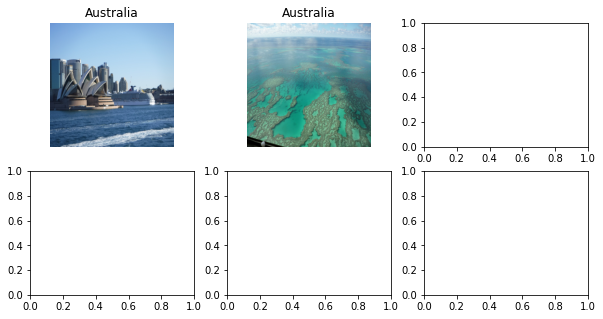

In [ ]:
#正解した画像を表示
flg, axes = plt.subplots(2, 3, figsize=(10, 5))

for i in range(count_correct):
  ax = axes[i // 3][i % 3]
  ax.set_title(label_names[correct_label[i]])
  ax.axis("off")
  ax.imshow(correct_data[i])

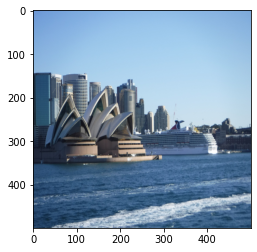

In [ ]:
plt.imshow(correct_data[0])

# 以下は、参考情報：生成AIとのやりとりをメモとして残しておく
プログラムとして採用しなかったが、クラス名をCNNの出力にする方法（標準的でない）

In [ ]:
# データパスの設定：下記はGoogle DriveのColab_filesフォルダの下にimage_dataフォルダを置いた場合
# 置いた場所に応じて適宜書き換えて下さい【必須】
data_path = '/content/drive/MyDrive/Colab_files/image_data'

# 各ディレクトリの画像に与えるラベル
# Vatican_Cityは写真が1枚だけなので、今回はデータとしては読み込まない
label_dict = {"USA": 0, "Italy": 1, "Australia": 2, "Austria": 3}

# 学習用のデータ（画像のリストと、ラベルのリスト）を作る。最初は空リストに初期化。
image_list = []
label_list = []

for dir in os.listdir(data_path):
    dataset_path = os.path.join(data_path, dir)
    label = dir

    if label == "USA" or label == "Italy" or label == "Australia" or label == "Austria":
        for file in os.listdir(dataset_path):
            label_list.append(label)  # label_listに正解ラベルを追加
            filepath = os.path.join(dataset_path, file)
            print(filepath)
            image = Image.open(filepath)
            image = image.resize((500, 500), Image.BICUBIC)  # Bicubic補間で500x500ピクセルに変換
            image = np.asarray(image)
            image_list.append(image / 255.)  # ピクセル値を0から1の範囲に正規化してimage_listに画像を追加
    else:
        print(f"Skipping directory: {dir} (unknown label)")

# kerasに渡すためにnumpy配列に変換。
X = np.array(image_list)
Y = np.array(label_list)

あなた モデルへの入力は文字列は含みません。モデルの出力が文字列です。

Gemini I apologize for my previous response, which was incorrect.

Since the model output is strings, you need to change the activation function of the last layer to tf.keras.activations.serialize. This activation function converts the output of the model to strings.

Here's the modified code:

model = tf.keras.Sequential([ tf.keras.layers.Conv2D(16, (3, 3), input_shape=(500, 500, 3), activation="relu"), tf.keras.layers.MaxPool2D((2, 2)), tf.keras.layers.Conv2D(32, (3, 3), activation="relu"), tf.keras.layers.MaxPool2D((2, 2)), tf.keras.layers.Flatten(), tf.keras.layers.Dense(16), tf.keras.layers.Dense(4, activation=tf.keras.activations.serialize) ]) Use code with caution This should fix the error and allow the model to output strings.

ソース yoshisatoh/ML stackoverflow.com/questions/62245075/model-accuracy-not-increasing-while-using-tensorflow-datasets

あなた 元は出力が0,1,2,3のどれかだったのを、4種類の文字列に変更したいのですが、先ほどの変更で合っていますか？

Gemini Yes, the change I suggested in my previous response should allow you to change the output of the model from integers (0, 1, 2, 3) to strings.

Here's how it works:

The tf.keras.activations.serialize activation function converts the output of the model to strings. By default, the serialize activation function uses the names of the classes as the strings. In your case, you have 4 classes, so the model will output one of the following strings: "0", "1", "2", or "3". If you want to use different strings, you can pass a list of strings to the serialize activation function. For example, the following code would make the model output the strings "apple", "banana", "cherry", and "mango":

model = tf.keras.Sequential([ # ... same as before ... tf.keras.layers.Dense(4, activation=tf.keras.activations.serialize(["apple", "banana", "cherry", "mango"])) ]) Use code with caution I hope this helps!